# Prepare

In [1]:
import argparse
import json
import os

import numpy as np
import sklearn.metrics
import torch
from torch import optim

from lib.suggested.self_attention_with_cnn import SelfAttentionCnnClassifier
from lib.embedding import load_full_embedding_with_vocab
from lib.reader import WikiqaReader, filtered_ref_generator
from lib.train import train_model, get_label_score
from lib.transformer import NoamOpt

In [2]:
config_path = 'models/suggested/self_attention_with_cnn/config.json'

In [3]:
with open(config_path, 'r') as fread:
    config_dict = json.load(fread)

# path
path_config = config_dict['Path']
model_dir = path_config['model_dir']
train = path_config['train']
dev = path_config['dev']
dev_ref = path_config['dev_ref']
test = path_config['test']
test_ref = path_config['test_ref']

words_embed, words_vocab = load_full_embedding_with_vocab(path_config['embed_dir'])
vocabs = {'q_words': words_vocab, 'a_words': words_vocab}

# model
model_config = config_dict['Model']
conv_width = model_config['conv_width']
out_channels = model_config['out_channels']
hidden_size = model_config['hidden_size']
cuda_device = model_config['cuda_device']
dropout = model_config['dropout']
h = model_config['h']
d_ff = model_config['d_ff']

clf = SelfAttentionCnnClassifier(words_embed=words_embed, out_channels=out_channels,
            conv_width=conv_width, hidden_size=hidden_size, cuda_device=None,
            h=h, d_ff=d_ff, dropout=dropout)

In [4]:
clf.load_state_dict(torch.load(os.path.join(model_dir, 'net.pt')))

In [5]:
dev_reader = WikiqaReader(dev, PAD_TOKEN='<pad>')
dev_reader.set_vocabs(vocabs)

# state_dict

In [6]:
state_dict = torch.load(os.path.join(model_dir, 'net.pt'))

In [7]:
state_dict.keys()

odict_keys(['embed.weight', 'pos_enc.pe', 'q_mha1.linears.0.weight', 'q_mha1.linears.0.bias', 'q_mha1.linears.1.weight', 'q_mha1.linears.1.bias', 'q_mha1.linears.2.weight', 'q_mha1.linears.2.bias', 'q_mha1.linears.3.weight', 'q_mha1.linears.3.bias', 'q_mha2.linears.0.weight', 'q_mha2.linears.0.bias', 'q_mha2.linears.1.weight', 'q_mha2.linears.1.bias', 'q_mha2.linears.2.weight', 'q_mha2.linears.2.bias', 'q_mha2.linears.3.weight', 'q_mha2.linears.3.bias', 'q_ffn.w_1.weight', 'q_ffn.w_1.bias', 'q_ffn.w_2.weight', 'q_ffn.w_2.bias', 'q_layer_norms.0.weight', 'q_layer_norms.0.bias', 'q_layer_norms.1.weight', 'q_layer_norms.1.bias', 'q_layer_norms.2.weight', 'q_layer_norms.2.bias', 'a_mha1.linears.0.weight', 'a_mha1.linears.0.bias', 'a_mha1.linears.1.weight', 'a_mha1.linears.1.bias', 'a_mha1.linears.2.weight', 'a_mha1.linears.2.bias', 'a_mha1.linears.3.weight', 'a_mha1.linears.3.bias', 'a_mha2.linears.0.weight', 'a_mha2.linears.0.bias', 'a_mha2.linears.1.weight', 'a_mha2.linears.1.bias', 'a_m

In [8]:
len(state_dict.keys())

30

In [9]:
len(list(clf.parameters()))

29

In [10]:
class TestModule(torch.nn.Module):
    def __init__(self):
        super(TestModule, self).__init__()
        self.linear = torch.nn.Linear(100, 100)
        self.linears = torch.nn.ModuleList([torch.nn.Linear(100, 100) for _ in range(3)])

In [11]:
test_clf = TestModule()

In [12]:
test_clf.state_dict().keys()

odict_keys(['linear.weight', 'linear.bias', 'linears.0.weight', 'linears.0.bias', 'linears.1.weight', 'linears.1.bias', 'linears.2.weight', 'linears.2.bias'])

In [13]:
len(list(test_clf.parameters()))

8

In [41]:
torch.load('models/baseline/focus/net.pt').keys()

odict_keys(['embed.weight', 'conv1.weight', 'conv1.bias', 'convs.0.weight', 'convs.0.bias', 'convs.1.weight', 'convs.1.bias', 'convs.2.weight', 'convs.2.bias', 'hidden1.weight', 'hidden1.bias', 'hidden2.weight', 'hidden2.bias'])

# Debug

In [8]:
dev_iterator = dev_reader.get_dataset_iterator(10, train=False, sort=False)

In [9]:
batch = next(iter(dev_iterator))

In [10]:
batch


[torchtext.data.batch.Batch of size 10]
	[.q_words]:[torch.LongTensor of size 10x9]
	[.a_words]:[torch.LongTensor of size 10x52]
	[.label]:[torch.LongTensor of size 10]

In [18]:
q_words = batch.q_words.cuda()
a_words = batch.a_words.cuda()
label = batch.label.cuda()

In [12]:
q_words = batch.q_words
a_words = batch.a_words
label = batch.label

## Embedding

In [10]:
clf.embed

Embedding(2470721, 50)

In [11]:
clf.embed.weight[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
clf.embed.weight[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
clf.embed.weight[2]

tensor([ 0.3599, -0.9806,  0.6490,  0.6391, -0.3194,  0.4745,  0.0142, -0.5854,
        -0.1329, -0.3566,  1.4825,  0.6276, -0.4546, -0.3539, -0.0517,  0.4643,
        -1.0893,  0.0997,  0.2904,  0.3147,  0.1732,  0.8788, -0.0925,  0.4679,
         0.0924, -0.6042,  1.2915, -0.6668, -0.6697,  0.0316,  0.4964,  0.2767,
         0.1808, -0.7954,  0.4086,  1.1201,  0.0318,  1.1545,  0.0073,  0.6567,
         0.3457, -0.1024, -0.8479,  0.1636,  0.1643,  0.3092, -1.2851,  1.1663,
         0.2186,  1.0116])

### forward

In [14]:
q_words[0]

tensor([1012269,  355012, 1074972,  374572, 1997409, 1049602, 1011785,   40530,
        2201719])

In [15]:
clf.embed(q_words[0])

tensor([[-0.0153,  0.1667, -0.2303, -0.0355, -0.3398, -0.2279, -0.1315,  0.0350,
          0.0603, -0.0577, -0.1365,  0.0305, -0.2955,  0.0547,  0.0520,  0.0665,
         -0.5095,  0.0924, -0.2522,  0.2532, -0.3016, -0.1758,  0.0277, -0.2793,
         -0.1166, -0.0111,  0.1673,  0.0854, -0.1373, -0.0949, -0.3816, -0.0853,
         -0.2936, -0.1023, -0.4602,  0.0628,  0.4433, -0.2157,  0.4328, -0.1458,
          0.1549, -0.5446,  0.4038, -0.0261,  0.2631, -0.0451,  0.0474,  0.0143,
         -0.4142, -0.0857],
        [-0.1885, -0.0042, -0.2205, -0.0547,  0.1802, -0.1991, -0.0735, -0.1208,
          0.0293, -0.3213, -0.0603, -0.3856, -0.0209,  0.0646, -0.2272,  0.0169,
         -0.5267,  0.1348, -0.2191,  0.0507, -0.3143,  0.1263, -0.1166, -0.2018,
          0.2915, -0.1627,  0.0612,  0.1495,  0.0466, -0.2522, -0.2725,  0.0968,
         -0.3424,  0.1331,  0.0169, -0.2545,  0.0585,  0.0785, -0.1787, -0.4401,
         -0.0577, -0.2181,  0.0790,  0.1681,  0.1416,  0.4151, -0.2538, -0.3202,


In [16]:
a_words[0]

tensor([ 374572, 1997409,   40530, 1050505, 1074972,  214259,  209213,  543469,
        2013082, 1049602,  428200, 1931636, 1347365,   16617,  415949,   39867,
        1997409,   41681,       1,       1,       1,       1,       1,       1,
              1,       1,       1,       1,       1,       1,       1,       1,
              1,       1,       1,       1,       1,       1,       1,       1,
              1,       1,       1,       1,       1,       1,       1,       1,
              1,       1,       1,       1])

In [17]:
clf.embed(a_words[0])

tensor([[ 0.1247, -0.4387, -0.0803,  ..., -0.1050, -0.0534,  0.3139],
        [-0.3404, -0.6952,  0.0498,  ...,  0.0045, -0.2617,  0.7092],
        [ 0.1958, -0.7127,  0.3720,  ...,  0.4471,  0.3583,  0.0318],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [13]:
q_sent_mat = clf.embed(q_words)

In [14]:
a_sent_mat = clf.embed(a_words)

In [21]:
q_sent_mat

tensor([[[-0.0153,  0.1667, -0.2303,  ...,  0.0143, -0.4142, -0.0857],
         [-0.1885, -0.0042, -0.2205,  ..., -0.3202, -0.1337,  0.0526],
         [-0.0590,  0.4907, -0.1367,  ..., -0.0004, -0.1227, -0.1360],
         ...,
         [ 0.3059, -0.2014, -0.2677,  ..., -0.1609, -0.0274,  0.1008],
         [ 0.1958, -0.7127,  0.3720,  ...,  0.4471,  0.3583,  0.0318],
         [ 0.1910, -0.0359, -0.2472,  ..., -0.0887,  0.3494,  0.0043]],

        [[-0.0153,  0.1667, -0.2303,  ...,  0.0143, -0.4142, -0.0857],
         [-0.1885, -0.0042, -0.2205,  ..., -0.3202, -0.1337,  0.0526],
         [-0.0590,  0.4907, -0.1367,  ..., -0.0004, -0.1227, -0.1360],
         ...,
         [ 0.3059, -0.2014, -0.2677,  ..., -0.1609, -0.0274,  0.1008],
         [ 0.1958, -0.7127,  0.3720,  ...,  0.4471,  0.3583,  0.0318],
         [ 0.1910, -0.0359, -0.2472,  ..., -0.0887,  0.3494,  0.0043]],

        [[-0.0153,  0.1667, -0.2303,  ...,  0.0143, -0.4142, -0.0857],
         [-0.1885, -0.0042, -0.2205,  ..., -0

In [22]:
a_sent_mat

tensor([[[ 0.1247, -0.4387, -0.0803,  ..., -0.1050, -0.0534,  0.3139],
         [-0.3404, -0.6952,  0.0498,  ...,  0.0045, -0.2617,  0.7092],
         [ 0.1958, -0.7127,  0.3720,  ...,  0.4471,  0.3583,  0.0318],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0283,  0.1306, -0.1471,  ...,  0.6354, -0.4958,  0.8075],
         [ 0.1027,  0.2431, -0.0924,  ..., -0.1255, -0.4254,  0.2351],
         [ 0.3059, -0.2014, -0.2677,  ..., -0.1609, -0.0274,  0.1008],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.3069,  0.4625, -0.1742,  ...,  0.6627,  0.1058,  0.2023],
         [ 0.0010,  0.3846, -0.3412,  ..., -0

## MultiHeadedAttention

In [18]:
clf.q_mha1

MultiHeadedAttention(
  (dropout): Dropout(p=0.3)
)

In [19]:
clf.q_mha1.linears

[Linear(in_features=50, out_features=50, bias=True),
 Linear(in_features=50, out_features=50, bias=True),
 Linear(in_features=50, out_features=50, bias=True),
 Linear(in_features=50, out_features=50, bias=True)]

In [20]:
clf.q_mha1.linears[0].weight

Parameter containing:
tensor([[-0.0877,  0.0912, -0.0862,  ...,  0.1060,  0.0327, -0.1133],
        [-0.1075,  0.1384, -0.0464,  ..., -0.0074,  0.1035, -0.0381],
        [-0.0514, -0.1118,  0.0545,  ...,  0.0665,  0.0012, -0.0602],
        ...,
        [ 0.1164,  0.0207,  0.0032,  ...,  0.0822,  0.0012, -0.1042],
        [ 0.0724,  0.0514, -0.0262,  ...,  0.0692, -0.1114,  0.0206],
        [-0.0266,  0.1147, -0.0986,  ...,  0.0769, -0.0296,  0.0122]],
       requires_grad=True)

In [21]:
clf.q_mha1.linears[0].weight.std()

tensor(0.0808, grad_fn=<StdBackward0>)

In [22]:
clf.q_mha1.linears[0].weight.mean()

tensor(-0.0050, grad_fn=<MeanBackward1>)

### forward

In [15]:
q_mask = (q_words > 1).unsqueeze(-2)

In [16]:
a_mask = (a_words > 1).unsqueeze(-2)

In [33]:
q_mask.size()

torch.Size([10, 1, 9])

In [34]:
a_mask.size()

torch.Size([10, 1, 52])

In [47]:
clf.q_mha1.linears[0].bias

Parameter containing:
tensor([-0.0482,  0.1396, -0.0015, -0.1236, -0.0139, -0.1201,  0.0278, -0.1357,
         0.1287,  0.1272,  0.1220,  0.0316, -0.0779, -0.0061, -0.0075,  0.1313,
        -0.1304, -0.0600, -0.0348,  0.0143, -0.1155, -0.0555, -0.0945, -0.1112,
        -0.0034,  0.0828, -0.1038,  0.1385,  0.0880,  0.1238, -0.0221,  0.0318,
         0.1118,  0.0175, -0.0107,  0.0230, -0.1216,  0.0024,  0.1090, -0.0051,
        -0.0890,  0.1279,  0.1500, -0.0749, -0.0975,  0.1205, -0.0254,  0.0247,
         0.0045, -0.0044], requires_grad=True)

In [23]:
query = clf.q_mha1.linears[0](q_sent_mat).split(h, dim=-1)[0]
key = clf.q_mha1.linears[1](q_sent_mat).split(h, dim=-1)[0]
value = clf.q_mha1.linears[2](q_sent_mat).split(h, dim=-1)[0]

In [27]:
score = torch.matmul(query, key.transpose(-2, -1))

In [28]:
score.size()

torch.Size([10, 9, 9])

In [31]:
query[0, 0]

tensor([ 0.0243, -0.0945,  0.0849, -0.0130,  0.2902, -0.3012,  0.0222, -0.2183,
         0.3818,  0.0180], grad_fn=<SelectBackward>)

In [32]:
key[0, 0]

tensor([-0.1021, -0.1784,  0.0670, -0.2595, -0.2801, -0.1237,  0.1974, -0.1476,
        -0.4013, -0.0143], grad_fn=<SelectBackward>)

In [30]:
torch.nn.functional.softmax(score, dim=-1)

tensor([[[0.0984, 0.1281, 0.1084, 0.1029, 0.1221, 0.1020, 0.1174, 0.0989,
          0.1218],
         [0.1101, 0.1226, 0.1107, 0.1038, 0.1218, 0.1060, 0.1086, 0.1040,
          0.1123],
         [0.1124, 0.1124, 0.1102, 0.1081, 0.1248, 0.1080, 0.1027, 0.1160,
          0.1055],
         [0.1146, 0.1083, 0.1091, 0.1112, 0.1217, 0.1057, 0.1033, 0.1207,
          0.1054],
         [0.1052, 0.1160, 0.1074, 0.1098, 0.1353, 0.1002, 0.1091, 0.1059,
          0.1111],
         [0.1107, 0.1167, 0.1127, 0.1047, 0.1241, 0.1076, 0.1073, 0.1045,
          0.1117],
         [0.1064, 0.1153, 0.1080, 0.1058, 0.1281, 0.1076, 0.1079, 0.1054,
          0.1157],
         [0.1240, 0.1045, 0.1070, 0.1207, 0.1263, 0.1093, 0.0947, 0.1227,
          0.0908],
         [0.0973, 0.1124, 0.1042, 0.0996, 0.1179, 0.1059, 0.1172, 0.1128,
          0.1326]],

        [[0.0984, 0.1281, 0.1084, 0.1029, 0.1221, 0.1020, 0.1174, 0.0989,
          0.1218],
         [0.1101, 0.1226, 0.1107, 0.1038, 0.1218, 0.1060, 0.1086, 0.

In [17]:
q_mha1_out = clf.q_mha1(q_sent_mat, q_sent_mat, q_sent_mat, q_mask)

In [19]:
q_mha1_out

tensor([[[ 0.0391,  0.0480,  0.0301,  ...,  0.0084,  0.0334, -0.0837],
         [ 0.0528,  0.0073,  0.0112,  ...,  0.0315, -0.0214, -0.0647],
         [ 0.0707,  0.0431,  0.0256,  ...,  0.0258,  0.0221, -0.0971],
         ...,
         [ 0.0401,  0.0335,  0.0406,  ...,  0.0163, -0.0285, -0.0727],
         [ 0.0417,  0.0231,  0.0361,  ...,  0.0317, -0.0031, -0.0394],
         [ 0.0630,  0.0205,  0.0040,  ...,  0.0018,  0.0130, -0.1145]],

        [[ 0.0552,  0.0529,  0.0488,  ...,  0.0360,  0.0058, -0.0817],
         [ 0.0346,  0.0479,  0.0558,  ..., -0.0444,  0.0386, -0.0810],
         [ 0.0501,  0.0359,  0.0252,  ..., -0.0006,  0.0147, -0.0492],
         ...,
         [ 0.0582,  0.0501,  0.0348,  ...,  0.0268,  0.0228, -0.0906],
         [ 0.0644,  0.0444,  0.0361,  ..., -0.0050,  0.0139, -0.1152],
         [ 0.0408,  0.0315,  0.0522,  ..., -0.0022, -0.0048, -0.0832]],

        [[ 0.0404,  0.0314,  0.0256,  ..., -0.0222,  0.0002, -0.0634],
         [ 0.0414,  0.0298,  0.0121,  ...,  0

In [28]:
q_mha1_out.mean()

tensor(0.0028, device='cuda:0', grad_fn=<MeanBackward1>)

In [29]:
q_mha1_out.std()

tensor(0.1089, device='cuda:0', grad_fn=<StdBackward0>)

In [18]:
a_mha1_out = clf.a_mha1(a_sent_mat, a_sent_mat, a_sent_mat, a_mask)

## LayerNorm

In [50]:
print(clf.q_layer_norms[0].weight)
print(clf.q_layer_norms[0].bias)

Parameter containing:
tensor([0.9947, 0.9934, 1.0030, 1.0016, 0.9930, 1.0005, 1.0011, 1.0006, 1.0002,
        0.9945, 0.9977, 0.9944, 1.0037, 0.9961, 0.9966, 1.0029, 0.9966, 0.9940,
        0.9966, 0.9926, 0.9956, 0.9970, 0.9993, 1.0022, 0.9934, 0.9982, 0.9941,
        1.0013, 0.9977, 0.9986, 1.0014, 1.0043, 1.0031, 0.9890, 1.0099, 0.9898,
        0.9944, 0.9970, 1.0007, 0.9907, 0.9964, 0.9997, 1.0002, 0.9962, 0.9932,
        1.0001, 0.9965, 0.9933, 0.9944, 1.0029], requires_grad=True)
Parameter containing:
tensor([ 0.0016, -0.0057, -0.0022,  0.0028,  0.0006,  0.0016, -0.0005,  0.0009,
        -0.0026,  0.0078,  0.0011,  0.0013,  0.0002, -0.0008,  0.0003, -0.0011,
         0.0033,  0.0001,  0.0025, -0.0047,  0.0023,  0.0007,  0.0038,  0.0002,
         0.0025,  0.0027, -0.0053, -0.0005,  0.0009, -0.0072,  0.0023, -0.0021,
        -0.0042,  0.0047, -0.0032, -0.0007, -0.0034,  0.0037,  0.0033,  0.0022,
        -0.0031, -0.0016,  0.0026,  0.0037, -0.0013,  0.0039,  0.0003, -0.0093,
       

In [51]:
print(clf.a_layer_norms[0].weight)
print(clf.a_layer_norms[0].bias)

Parameter containing:
tensor([1.0114, 0.9989, 1.0138, 1.0031, 1.0166, 1.0082, 1.0045, 1.0245, 1.0204,
        0.9838, 0.9908, 1.0070, 0.9895, 1.0107, 0.9965, 0.9879, 0.9918, 0.9999,
        0.9820, 1.0116, 1.0160, 1.0184, 1.0014, 1.0062, 0.9837, 1.0219, 1.0033,
        0.9924, 1.0056, 1.0006, 1.0245, 0.9931, 1.0027, 1.0019, 1.0030, 1.0104,
        1.0042, 0.9970, 1.0086, 0.9894, 1.0044, 1.0008, 1.0073, 0.9959, 1.0131,
        1.0180, 1.0126, 1.0036, 1.0159, 0.9910], requires_grad=True)
Parameter containing:
tensor([ 0.0007, -0.0090, -0.0005, -0.0014, -0.0001, -0.0031,  0.0005, -0.0014,
        -0.0002,  0.0160, -0.0071,  0.0076, -0.0073,  0.0008, -0.0021, -0.0166,
         0.0116,  0.0075,  0.0045,  0.0062,  0.0001,  0.0016,  0.0006, -0.0031,
        -0.0128, -0.0016, -0.0001,  0.0046, -0.0000, -0.0067,  0.0106, -0.0186,
         0.0112,  0.0029,  0.0049, -0.0039, -0.0009,  0.0100,  0.0039,  0.0012,
        -0.0104, -0.0033,  0.0003,  0.0140, -0.0013,  0.0055, -0.0016,  0.0017,
       

---

# gradient

In [11]:
from lib.train import train_model

In [12]:
optimizer = torch.optim.Adam(clf.parameters())

In [13]:
train_model(clf, optimizer, dev_iterator, label_name='label',
            num_epoch=1, cuda_device=None, early_stopping=0,
            input_names=['q_words', 'a_words'], callback=None, verbose=False)

In [66]:
clf.hidden2.weight.grad

tensor([[-0.0117,  0.0000, -0.0012,  0.0000,  0.0000,  0.0000,  0.0000, -0.0213,
         -0.0045,  0.0000, -0.0001, -0.0199, -0.0001,  0.0000,  0.0000, -0.0084,
         -0.0020, -0.0232,  0.0000, -0.0219, -0.0278, -0.0000, -0.0090, -0.0191,
         -0.0110,  0.0000,  0.0000,  0.0000,  0.0000, -0.0005, -0.0197,  0.0000,
         -0.0172, -0.0343,  0.0000, -0.0086,  0.0000, -0.0278,  0.0000, -0.0005,
         -0.0188, -0.0045,  0.0000, -0.0009,  0.0000, -0.0154,  0.0000, -0.0239,
         -0.0141,  0.0000,  0.0000,  0.0000, -0.0034,  0.0000, -0.0063,  0.0000,
          0.0000,  0.0000,  0.0000, -0.0150, -0.0044,  0.0000, -0.0144, -0.0445,
         -0.0114, -0.0096, -0.0000, -0.0116,  0.0000, -0.0203,  0.0000, -0.0367,
         -0.0242, -0.0029, -0.0290,  0.0000,  0.0000, -0.0063, -0.0026, -0.0033,
          0.0000,  0.0000,  0.0000, -0.0064, -0.0171,  0.0000, -0.0199,  0.0000,
          0.0000,  0.0000,  0.0000, -0.0089, -0.0273, -0.0102,  0.0000, -0.0177,
         -0.0007, -0.0359,  

In [91]:
clf.hidden2.weight.grad.abs().mean()

tensor(0.0063)

In [92]:
clf.hidden2.weight.grad[(clf.hidden2.weight.grad != 0)].abs().mean()

tensor(0.0115)

In [70]:
(clf.hidden2.weight.grad == 0).sum()

tensor(180)

In [71]:
clf.hidden2.weight.size()

torch.Size([2, 200])

In [75]:
print((clf.hidden1.weight.grad == 0).sum())
print(clf.hidden1.weight.size())

tensor(18000)
torch.Size([200, 200])


In [80]:
print(clf.a_layer_norms[2].weight.grad)
print(clf.a_layer_norms[2].bias.grad)

tensor([-0.0036,  0.0037, -0.0028,  0.0018,  0.0011, -0.0037, -0.0043,  0.0032,
        -0.0009,  0.0008,  0.0048,  0.0002,  0.0006, -0.0015, -0.0018, -0.0004,
        -0.0051, -0.0015,  0.0028, -0.0011,  0.0008,  0.0018,  0.0017,  0.0012,
         0.0011, -0.0009,  0.0001,  0.0012, -0.0012,  0.0002, -0.0004, -0.0002,
         0.0051,  0.0007, -0.0015, -0.0018, -0.0023,  0.0013,  0.0002, -0.0007,
        -0.0024, -0.0035,  0.0008,  0.0006, -0.0009, -0.0010, -0.0046,  0.0033,
         0.0006, -0.0029])
tensor([ 0.0065, -0.0009,  0.0054, -0.0005,  0.0079,  0.0122, -0.0039, -0.0019,
         0.0044, -0.0008,  0.0062,  0.0080, -0.0015,  0.0014,  0.0043, -0.0021,
         0.0057,  0.0071,  0.0049, -0.0051,  0.0031,  0.0024, -0.0053, -0.0028,
         0.0002, -0.0059,  0.0024,  0.0015, -0.0024, -0.0032, -0.0020,  0.0003,
        -0.0049, -0.0026,  0.0028, -0.0037, -0.0053, -0.0005, -0.0005,  0.0041,
        -0.0067, -0.0015, -0.0054, -0.0016, -0.0024,  0.0059, -0.0091,  0.0065,
        -0.00

In [81]:
print(clf.a_layer_norms[1].weight.grad)
print(clf.a_layer_norms[1].bias.grad)

tensor([-0.0025,  0.0016, -0.0012,  0.0031,  0.0027, -0.0032, -0.0025,  0.0008,
         0.0001, -0.0004,  0.0058,  0.0032,  0.0008, -0.0023, -0.0022, -0.0001,
        -0.0080, -0.0009,  0.0014, -0.0016,  0.0006,  0.0022,  0.0020,  0.0029,
         0.0017,  0.0022,  0.0015,  0.0010,  0.0000, -0.0001, -0.0011, -0.0009,
         0.0070,  0.0011, -0.0020, -0.0014, -0.0011,  0.0008, -0.0000, -0.0012,
        -0.0026, -0.0025,  0.0019,  0.0010, -0.0019, -0.0009, -0.0034,  0.0058,
         0.0005, -0.0060])
tensor([ 0.0072, -0.0013,  0.0061, -0.0014,  0.0075,  0.0134, -0.0044, -0.0001,
         0.0037,  0.0001,  0.0054,  0.0068, -0.0015,  0.0015,  0.0023, -0.0008,
         0.0062,  0.0069,  0.0021, -0.0064,  0.0033,  0.0021, -0.0052, -0.0014,
         0.0006, -0.0031,  0.0042,  0.0012, -0.0010, -0.0017, -0.0027, -0.0004,
        -0.0053, -0.0016,  0.0027, -0.0044, -0.0047, -0.0019, -0.0020,  0.0014,
        -0.0067, -0.0014, -0.0058, -0.0027, -0.0033,  0.0050, -0.0088,  0.0046,
        -0.00

In [82]:
print(clf.a_layer_norms[0].weight.grad)
print(clf.a_layer_norms[0].bias.grad)

tensor([-0.0027,  0.0011, -0.0020,  0.0023,  0.0029, -0.0033, -0.0024,  0.0008,
         0.0008, -0.0003,  0.0074,  0.0040,  0.0005, -0.0023, -0.0020,  0.0000,
        -0.0067, -0.0027,  0.0006, -0.0004,  0.0001,  0.0021,  0.0015,  0.0029,
         0.0021,  0.0019,  0.0013,  0.0006,  0.0005, -0.0005, -0.0010, -0.0009,
         0.0080,  0.0015, -0.0019, -0.0019, -0.0022,  0.0007,  0.0006, -0.0013,
        -0.0025, -0.0020,  0.0013,  0.0017, -0.0023,  0.0006, -0.0043,  0.0056,
         0.0001, -0.0074])
tensor([ 0.0071, -0.0020,  0.0069, -0.0019,  0.0079,  0.0138, -0.0048,  0.0002,
         0.0034, -0.0002,  0.0057,  0.0064, -0.0016,  0.0015,  0.0026, -0.0007,
         0.0057,  0.0068,  0.0022, -0.0069,  0.0028,  0.0026, -0.0057, -0.0010,
         0.0012, -0.0034,  0.0042,  0.0019, -0.0003, -0.0023, -0.0033, -0.0002,
        -0.0058, -0.0024,  0.0032, -0.0046, -0.0047, -0.0014, -0.0024,  0.0008,
        -0.0067, -0.0008, -0.0055, -0.0035, -0.0041,  0.0049, -0.0091,  0.0040,
        -0.00

In [84]:
print(clf.a_ffn.w_1.weight.grad)
print(clf.a_ffn.w_1.bias.grad)

tensor([[ 0.0002,  0.0018, -0.0005,  ..., -0.0007, -0.0000, -0.0006],
        [ 0.0001,  0.0018, -0.0002,  ..., -0.0016, -0.0008, -0.0002],
        [ 0.0003,  0.0007, -0.0006,  ..., -0.0006, -0.0003, -0.0007],
        ...,
        [ 0.0003,  0.0006, -0.0001,  ...,  0.0004,  0.0002, -0.0002],
        [ 0.0004, -0.0005, -0.0000,  ..., -0.0009, -0.0004, -0.0001],
        [ 0.0004,  0.0000, -0.0007,  ...,  0.0001,  0.0005, -0.0001]])
tensor([-0.0010, -0.0005, -0.0002,  0.0002,  0.0001,  0.0020, -0.0010, -0.0000,
        -0.0011,  0.0004,  0.0002,  0.0015, -0.0008, -0.0001, -0.0005,  0.0000,
        -0.0004, -0.0004, -0.0005, -0.0006,  0.0008,  0.0007,  0.0008, -0.0007,
         0.0012,  0.0012, -0.0001,  0.0008,  0.0001, -0.0001, -0.0012,  0.0004,
         0.0022,  0.0004,  0.0007, -0.0006,  0.0006, -0.0006,  0.0022, -0.0004,
        -0.0014, -0.0012, -0.0000,  0.0001,  0.0003,  0.0012,  0.0005,  0.0028,
         0.0002,  0.0010,  0.0017,  0.0004, -0.0008,  0.0006, -0.0004, -0.0014,
      

In [85]:
print(clf.a_ffn.w_2.weight.grad)
print(clf.a_ffn.w_2.bias.grad)

tensor([[ 0.0016,  0.0007,  0.0002,  ...,  0.0010,  0.0009,  0.0008],
        [-0.0012,  0.0012, -0.0009,  ...,  0.0009, -0.0014, -0.0005],
        [ 0.0013,  0.0011,  0.0005,  ...,  0.0012,  0.0012, -0.0000],
        ...,
        [ 0.0017, -0.0000,  0.0004,  ..., -0.0001,  0.0010,  0.0005],
        [-0.0006, -0.0004, -0.0005,  ..., -0.0004, -0.0011, -0.0007],
        [-0.0019,  0.0003, -0.0013,  ..., -0.0001, -0.0012, -0.0007]])
tensor([ 0.0059,  0.0003,  0.0053, -0.0022,  0.0072,  0.0119, -0.0041, -0.0006,
         0.0035, -0.0010,  0.0045,  0.0066, -0.0018,  0.0010,  0.0036, -0.0023,
         0.0053,  0.0065,  0.0040, -0.0058,  0.0030,  0.0020, -0.0047, -0.0022,
        -0.0006, -0.0041,  0.0021,  0.0021, -0.0009, -0.0036, -0.0025,  0.0005,
        -0.0048, -0.0019,  0.0017, -0.0040, -0.0048, -0.0016, -0.0013,  0.0026,
        -0.0065, -0.0021, -0.0043, -0.0020, -0.0024,  0.0054, -0.0090,  0.0044,
        -0.0043, -0.0040])


In [86]:
print(clf.a_mha2.linears[0].weight.grad)
print(clf.a_mha2.linears[0].bias.grad)

tensor([[-0.0001, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0001],
        [-0.0001,  0.0001,  0.0001,  ..., -0.0001, -0.0001, -0.0000],
        [-0.0002,  0.0001,  0.0002,  ..., -0.0002, -0.0002,  0.0001],
        ...,
        [ 0.0000,  0.0000, -0.0001,  ..., -0.0003, -0.0002, -0.0001],
        [ 0.0000, -0.0003, -0.0001,  ...,  0.0004,  0.0004, -0.0000],
        [ 0.0000,  0.0003, -0.0002,  ..., -0.0004, -0.0003, -0.0001]])
tensor([ 1.0959e-04,  1.6361e-05,  1.7401e-04,  7.2125e-05,  3.2807e-04,
        -1.0629e-04,  5.3922e-05,  2.5753e-04, -3.0069e-04,  4.5623e-04,
        -2.4182e-04,  1.2838e-04, -1.1899e-05,  1.2362e-04, -1.9651e-04,
        -3.9662e-05,  1.5254e-04, -3.1538e-05, -2.1276e-04,  1.5623e-04,
         4.0863e-05, -1.2068e-04,  2.0957e-04, -2.0596e-04,  3.2331e-04,
        -2.5232e-05,  2.9107e-04, -3.0936e-04, -2.4949e-04,  2.9088e-04,
         8.3857e-05,  4.3533e-04,  1.9532e-05,  8.8340e-05,  2.8200e-05,
         5.6540e-05,  1.2819e-04, -5.9726e-05, -4.0417e

In [93]:
print(clf.a_mha1.linears[0].weight.grad)
print(clf.a_mha1.linears[0].bias.grad)

tensor([[ 2.7186e-06, -9.2845e-06, -5.5886e-08,  ..., -3.2881e-06,
         -1.6022e-05,  2.9972e-06],
        [ 6.1626e-06, -1.7645e-05, -2.1505e-06,  ..., -1.2584e-06,
         -5.6265e-06,  4.4611e-06],
        [ 5.1153e-06, -2.4945e-05, -6.8601e-06,  ..., -1.8162e-05,
         -2.2849e-05, -8.4422e-07],
        ...,
        [-4.3891e-05, -5.2141e-06,  5.0523e-05,  ...,  2.2805e-05,
         -3.6387e-05, -7.9094e-06],
        [ 1.8308e-05,  1.6312e-06, -2.8325e-05,  ...,  6.5529e-06,
          3.0644e-05,  6.6337e-07],
        [-3.4199e-06,  1.0917e-06,  4.0286e-06,  ...,  7.3655e-06,
         -2.0266e-06, -1.8547e-06]])
tensor([ 1.0380e-04,  6.1468e-05,  1.7917e-04,  5.8693e-05, -1.5743e-04,
        -2.4759e-04,  9.6750e-05,  4.4369e-05, -2.0534e-04,  2.7656e-06,
        -2.4453e-04,  8.1951e-05, -2.2206e-04, -2.4834e-04, -1.8574e-04,
        -3.7961e-04,  1.5967e-04,  1.3082e-04, -1.5971e-04,  2.3459e-04,
         8.1737e-05, -9.6855e-06,  1.9250e-05,  3.9176e-05,  3.2481e-05,
   

In [88]:
clf.a_mha2.linears[0].weight.grad.abs().mean()

tensor(0.0001)

In [89]:
clf.a_mha2.linears[0].bias.grad.abs().mean()

tensor(0.0002)

In [94]:
clf.a_layer_norms[0].weight

Parameter containing:
tensor([1.0235, 1.0012, 1.0278, 1.0119, 1.0284, 1.0133, 1.0087, 1.0258, 1.0317,
        0.9790, 0.9916, 1.0137, 1.0016, 1.0287, 0.9850, 0.9813, 0.9918, 1.0067,
        0.9829, 1.0214, 1.0357, 1.0270, 0.9903, 1.0136, 0.9757, 1.0252, 1.0011,
        0.9784, 1.0164, 0.9943, 1.0281, 0.9892, 1.0110, 1.0079, 1.0040, 1.0125,
        1.0040, 0.9930, 1.0119, 0.9847, 1.0086, 1.0036, 1.0104, 0.9935, 1.0228,
        1.0238, 1.0135, 1.0081, 1.0214, 0.9853], requires_grad=True)

In [95]:
clf.a_mha2.linears[0].weight

Parameter containing:
tensor([[ 0.0350,  0.1171, -0.0649,  ...,  0.0499,  0.1135,  0.1156],
        [-0.1175,  0.1073, -0.0445,  ...,  0.0252,  0.0126, -0.1079],
        [-0.1208, -0.0053, -0.0589,  ..., -0.0507, -0.1120, -0.1375],
        ...,
        [-0.0391, -0.1288, -0.0262,  ..., -0.0056,  0.0013, -0.0043],
        [-0.1538, -0.1448,  0.0040,  ..., -0.0467, -0.0330,  0.0321],
        [-0.0521, -0.1164,  0.0519,  ...,  0.0520, -0.1157,  0.0291]],
       requires_grad=True)

In [96]:
clf.a_mha2.linears[3].weight

Parameter containing:
tensor([[-0.0892, -0.0708,  0.1139,  ..., -0.0102,  0.0059,  0.0893],
        [ 0.0974,  0.0504, -0.0525,  ..., -0.0387,  0.0901, -0.0687],
        [ 0.1484,  0.0394,  0.1242,  ..., -0.1020, -0.1252,  0.1021],
        ...,
        [ 0.0173,  0.0598, -0.0717,  ...,  0.0524,  0.1177, -0.0117],
        [-0.1055,  0.0173, -0.0266,  ...,  0.1139,  0.1239,  0.0277],
        [-0.1092, -0.1123,  0.0468,  ..., -0.0754,  0.1144,  0.1307]],
       requires_grad=True)

TODO 입력에 layernorm + sqrt(d_model)

---

# backward

## hidden2

In [15]:
clf.hidden2.weight

Parameter containing:
tensor([[ 0.0669,  0.0542,  0.0806,  0.0094, -0.0736, -0.0119, -0.0299, -0.0020,
         -0.0135,  0.0234, -0.0508,  0.0303, -0.0237,  0.0106,  0.0178, -0.0420,
          0.0902, -0.0233, -0.0780, -0.0353,  0.0279,  0.0622,  0.0635,  0.0163,
          0.0902, -0.0269, -0.0145, -0.0551, -0.0298,  0.0440,  0.0515, -0.0648,
          0.0834, -0.0389,  0.0178, -0.0216, -0.0485, -0.0612,  0.0257, -0.0472,
         -0.0630,  0.0075, -0.0173,  0.0240,  0.0087, -0.0362,  0.0420,  0.0600,
         -0.0116, -0.0124, -0.0585, -0.0650, -0.0337,  0.0419, -0.0324, -0.0383,
          0.0665,  0.0115,  0.0756, -0.0860,  0.0407,  0.0234,  0.0139,  0.0313,
         -0.0737, -0.0698,  0.0697,  0.0566,  0.0177,  0.0213,  0.0648, -0.0625,
         -0.0861,  0.0172, -0.0365,  0.0470,  0.0332,  0.0984,  0.1004, -0.0053,
          0.0132, -0.0014, -0.0795,  0.0404,  0.0392,  0.0397,  0.0752,  0.0341,
          0.0833,  0.0704, -0.0272,  0.0485,  0.0481,  0.0132,  0.0623,  0.0635,
      

In [16]:
clf.hidden2.weight.grad

tensor([[-0.0973,  0.0000,  0.0000,  0.0000, -0.0374, -0.0730, -0.0203,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0539,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.1251,  0.0000,  0.0000,  0.0000,  0.0000, -0.0105,  0.0000, -0.0134,
         -0.0685,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0724, -0.0944,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0002, -0.0464,  0.0000,  0.0000, -0.0199,  0.0000,  0.0000,
         -0.1178, -0.0991,  0.0000, -0.0020,  0.0000,  0.0000, -0.0132,  0.0000,
         -0.0348, -0.0704,  0.0000, -0.1263,  0.0000,  0.0000, -0.1146,  0.0000,
          0.0000,  0.0000, -0.1222, -0.0252,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.0472,  0.0000,  0.0000, -0.0090, -0.0392,  0.0000,
          0.0000,  0.0000, -0.0845,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0765,  

In [17]:
clf.hidden2.bias

Parameter containing:
tensor([ 0.0722, -0.0472], requires_grad=True)

In [18]:
clf.hidden2.bias.grad

tensor([-0.0844,  0.0844])

In [37]:
d_hidden2_out = clf.hidden2.bias.grad

In [38]:
d_hidden2_weight = clf.hidden2.weight.grad

In [39]:
hidden1_out = d_hidden2_weight[0] / d_hidden2_out[0]

In [33]:
hidden1_out

tensor([ 1.1532, -0.0000, -0.0000, -0.0000,  0.4427,  0.8646,  0.2405, -0.0000,
        -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         0.6386, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
         1.4831, -0.0000, -0.0000, -0.0000, -0.0000,  0.1238, -0.0000,  0.1588,
         0.8121, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000,  0.8584,  1.1193, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000,  0.0021,  0.5503, -0.0000, -0.0000,  0.2354, -0.0000, -0.0000,
         1.3960,  1.1746, -0.0000,  0.0238, -0.0000, -0.0000,  0.1561, -0.0000,
         0.4129,  0.8339, -0.0000,  1.4971, -0.0000, -0.0000,  1.3576, -0.0000,
        -0.0000, -0.0000,  1.4485,  0.2981, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000,  0.5590, -0.0000, -0.0000,  0.1065,  0.4643, -0.0000,
        -0.0000, -0.0000,  1.0013, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000,  0.9065, -0.0000, -0.00

In [35]:
print(hidden1_out.std())
print(hidden1_out.mean())

tensor(0.4640)
tensor(0.2296)


## hidden1

In [47]:
d_hidden1_out = torch.matmul(clf.hidden2.weight.transpose(-1, -2), d_hidden2_out)

In [49]:
d_hidden1_out

tensor([-0.0094, -0.0121, -0.0039,  0.0021,  0.0025, -0.0070,  0.0111, -0.0009,
        -0.0036, -0.0013,  0.0054, -0.0068,  0.0001,  0.0015, -0.0020,  0.0055,
        -0.0109,  0.0054,  0.0122,  0.0024, -0.0045, -0.0078, -0.0000, -0.0038,
        -0.0081,  0.0060,  0.0018,  0.0106,  0.0046, -0.0015, -0.0099,  0.0104,
        -0.0071, -0.0001, -0.0009,  0.0042, -0.0003,  0.0091,  0.0031,  0.0099,
         0.0087, -0.0016, -0.0047,  0.0010,  0.0010, -0.0013, -0.0052, -0.0052,
        -0.0070, -0.0061,  0.0050,  0.0118,  0.0007,  0.0005,  0.0043,  0.0026,
        -0.0071, -0.0065, -0.0137,  0.0048, -0.0067, -0.0054, -0.0015, -0.0058,
         0.0080,  0.0049, -0.0104, -0.0053, -0.0060,  0.0054, -0.0082,  0.0101,
         0.0123, -0.0033, -0.0014, -0.0072, -0.0017, -0.0165, -0.0154, -0.0044,
        -0.0004,  0.0019,  0.0083, -0.0009, -0.0008, -0.0086, -0.0017, -0.0061,
        -0.0120, -0.0075, -0.0056, -0.0025, -0.0051, -0.0013, -0.0039, -0.0070,
         0.0066, -0.0050,  0.0083,  0.00

In [48]:
d_hidden1_out.size()

torch.Size([200])

In [53]:
d_qa_repr = clf.hidden1.weight.grad[0] / d_hidden1_out[0]

In [56]:
d_qa_repr

tensor([ 2.5289,  1.2547,  0.8260,  0.2197,  0.8382,  0.8672,  0.7608, -0.0294,
         0.5976,  1.4946,  0.5367,  0.3743,  1.2062,  0.6231,  0.1984,  0.3699,
         0.3122,  1.2835,  0.6195,  0.2721,  0.3567,  0.8235,  0.8380,  0.3127,
         0.8329,  0.4929,  0.0235,  0.1697,  0.9710,  0.9173,  0.0927,  1.0165,
         0.2886,  0.6870, -0.0243,  0.8449,  0.2152,  0.5269,  0.6558,  0.4136,
         0.3419, -0.0192,  1.2533, -0.1454,  0.8146,  0.6156,  0.4494,  0.4562,
         0.5538,  0.2726,  0.9470,  0.5314,  0.3086, -0.0628,  0.4397,  1.0074,
         1.8691,  0.0779,  0.9111, -0.4070, -0.0257,  1.1572,  1.1506,  0.1263,
        -0.0060,  1.0250,  0.1090,  0.2816,  0.5260,  0.3783,  0.5473,  0.5807,
         0.6160, -0.7718,  0.9527,  1.3310,  0.8773,  0.8298,  1.2230,  0.5150,
        -0.0439,  0.0487, -0.0367,  0.5338,  0.4741,  0.0867,  0.6395,  0.0632,
         0.7153,  0.2974,  0.0822,  1.0862, -0.0203,  0.6785,  0.3303,  1.0619,
        -0.3189,  0.3578,  0.6541,  0.51

## answer conv

In [57]:
d_a_pool_out = d_qa_repr[100:]

In [58]:
d_a_pool_out

tensor([ 0.4311,  1.1577,  0.8556,  0.9323,  0.3436,  0.2456,  1.8852,  0.3765,
         0.4147,  0.1564,  0.5457,  0.6561,  0.8777,  0.5002,  0.2087,  0.9557,
         0.7937,  0.3303,  1.1872,  0.6965,  0.5448,  0.1897,  0.7210,  0.6019,
         1.6727,  0.3859,  1.2490,  0.9379,  0.9626,  0.6552,  1.0206,  0.2049,
         0.6442,  0.2717,  0.7906,  1.0158,  1.3968,  0.2007,  0.0257,  0.7205,
         0.6990,  0.5765,  0.7186,  0.1896,  0.4342,  0.5049,  0.5899,  0.8610,
         1.8891,  1.0291,  0.8355,  1.1124,  0.3331,  0.5749,  0.5827,  1.1480,
        -0.2350,  1.1399,  0.2018,  0.7280,  0.5614,  0.3886,  1.0630,  0.5802,
         1.1596, -0.2244,  0.1777,  1.0357,  0.3893,  1.1227,  0.5304,  1.0072,
         1.8712,  0.8251,  0.9585,  0.2296,  0.1588,  1.3492,  0.7293,  1.4046,
         0.7608,  0.0421,  0.4388,  0.7385,  0.5047,  0.4582,  0.7420,  0.9917,
         1.2975,  1.1983,  0.0946,  0.7374,  0.9766,  0.7225,  1.0511,  0.6825,
         0.8761,  1.2242,  1.0490,  0.67

In [59]:
clf.a_conv.weight

Parameter containing:
tensor([[[ 0.0059, -0.0355, -0.0578, -0.0720,  0.0454],
         [-0.0563, -0.0416, -0.0221,  0.0304, -0.0092],
         [-0.0092, -0.0393,  0.0490,  0.0161, -0.0284],
         ...,
         [ 0.0041,  0.0667, -0.0407,  0.0515,  0.0060],
         [-0.0542, -0.0254, -0.0210,  0.0235,  0.0297],
         [-0.0072, -0.0145, -0.0333,  0.0163, -0.0524]],

        [[ 0.0152,  0.0462,  0.0478,  0.0129, -0.0457],
         [ 0.0349, -0.0216, -0.0256,  0.0742,  0.0008],
         [ 0.0304,  0.0208,  0.0237, -0.0269,  0.0258],
         ...,
         [-0.0571, -0.0237, -0.0389,  0.0016, -0.0118],
         [-0.0325, -0.0941,  0.0506, -0.0748,  0.0898],
         [ 0.0372,  0.0545, -0.0342, -0.0503,  0.0455]],

        [[ 0.0353, -0.0223,  0.0134, -0.0186,  0.0649],
         [-0.0761, -0.0438, -0.0105,  0.1006,  0.0572],
         [-0.0281, -0.0518,  0.0437, -0.0622, -0.0535],
         ...,
         [ 0.0273,  0.0247,  0.0085,  0.0428,  0.0534],
         [-0.0536, -0.0439, -0.0281,

In [60]:
clf.a_conv.bias

Parameter containing:
tensor([-0.0049,  0.0562, -0.0516,  0.0274,  0.0515,  0.0199,  0.0701, -0.0239,
         0.0004, -0.0374, -0.0421,  0.0205, -0.0629, -0.0044,  0.0519, -0.0415,
        -0.0413, -0.0066,  0.0225, -0.0268,  0.0175, -0.0200, -0.0078,  0.0474,
        -0.0417,  0.0196,  0.0576,  0.0374, -0.0601,  0.0171,  0.0499, -0.0680,
         0.0072, -0.0285,  0.0543, -0.0356, -0.0576, -0.0079, -0.0422, -0.0476,
         0.0267, -0.0377, -0.0064, -0.0188,  0.0506, -0.0396, -0.0122,  0.0406,
         0.0561,  0.0344,  0.0476,  0.0635, -0.0548,  0.0520, -0.0635,  0.0424,
        -0.0593, -0.0328,  0.0327, -0.0382,  0.0339,  0.0494,  0.0266, -0.0607,
         0.0240,  0.0125,  0.0294,  0.0474, -0.0071,  0.0122, -0.0674,  0.0485,
         0.0424,  0.0383,  0.0582,  0.0029, -0.0336,  0.0082, -0.0177, -0.0644,
        -0.0017, -0.0306, -0.0425,  0.0047, -0.0309, -0.0506, -0.0291,  0.0238,
         0.0159,  0.0414, -0.0389, -0.0634, -0.0498,  0.0309, -0.0116,  0.0120,
         0.0353, -

---

## a_layer_norms[2]

In [63]:
clf.a_layer_norms[2].weight.grad

tensor([-0.0004,  0.0042, -0.0031, -0.0028, -0.0087, -0.0002,  0.0007,  0.0037,
        -0.0000, -0.0022,  0.0029, -0.0003, -0.0020,  0.0034, -0.0062, -0.0028,
        -0.0166, -0.0046,  0.0032, -0.0033, -0.0025,  0.0014, -0.0053, -0.0073,
         0.0003, -0.0016, -0.0005,  0.0032, -0.0025, -0.0014, -0.0025,  0.0017,
         0.0008,  0.0021,  0.0027, -0.0061, -0.0012, -0.0010, -0.0005,  0.0017,
        -0.0023, -0.0004,  0.0055,  0.0013, -0.0000,  0.0009,  0.0011, -0.0008,
         0.0019, -0.0043])

In [64]:
clf.a_layer_norms[2].bias.grad

tensor([ 0.0037, -0.0062, -0.0081,  0.0085,  0.0150, -0.0075,  0.0049, -0.0018,
        -0.0054,  0.0066,  0.0071, -0.0032, -0.0100,  0.0012,  0.0143,  0.0095,
         0.0133, -0.0064, -0.0032, -0.0146,  0.0020,  0.0051, -0.0091, -0.0115,
         0.0019, -0.0135,  0.0020, -0.0044,  0.0019,  0.0030,  0.0076, -0.0003,
         0.0002,  0.0009,  0.0038, -0.0056, -0.0070, -0.0037,  0.0020, -0.0013,
        -0.0087,  0.0008, -0.0127, -0.0047, -0.0066,  0.0031, -0.0046,  0.0062,
         0.0074, -0.0070])

In [73]:
clf.a_ffn.w_1.weight

Parameter containing:
tensor([[ 0.0315,  0.0728, -0.0640,  ..., -0.0580,  0.0483, -0.1332],
        [ 0.0889, -0.0123, -0.0713,  ..., -0.0070, -0.0080, -0.0218],
        [-0.1532,  0.0563,  0.0337,  ..., -0.0386, -0.1235, -0.0844],
        ...,
        [ 0.0647, -0.0826, -0.0966,  ..., -0.1010, -0.0877,  0.0432],
        [ 0.1351,  0.0110, -0.0701,  ...,  0.0513,  0.1228,  0.0743],
        [ 0.1110,  0.0761,  0.0967,  ...,  0.1381, -0.0495, -0.0617]],
       requires_grad=True)

In [82]:
print(clf.a_ffn.w_1.weight.grad)
print(clf.a_ffn.w_1.weight.grad.mean())
print(clf.a_ffn.w_1.weight.grad.std())

tensor([[-0.0005,  0.0016,  0.0002,  ..., -0.0010, -0.0008,  0.0010],
        [-0.0001, -0.0005,  0.0002,  ...,  0.0005,  0.0001, -0.0000],
        [ 0.0002,  0.0012,  0.0012,  ..., -0.0008, -0.0014,  0.0001],
        ...,
        [ 0.0002,  0.0009,  0.0006,  ...,  0.0000, -0.0003,  0.0006],
        [ 0.0005,  0.0026, -0.0010,  ..., -0.0007, -0.0005,  0.0009],
        [-0.0003,  0.0001, -0.0010,  ...,  0.0001,  0.0006, -0.0009]])
tensor(5.2628e-08)
tensor(0.0011)


In [83]:
print(clf.a_ffn.w_2.weight.grad)
print(clf.a_ffn.w_2.weight.grad.mean())
print(clf.a_ffn.w_2.weight.grad.std())

tensor([[ 0.0001,  0.0003,  0.0006,  ...,  0.0005,  0.0011,  0.0008],
        [-0.0001, -0.0000, -0.0011,  ...,  0.0002, -0.0016, -0.0002],
        [ 0.0003, -0.0002, -0.0006,  ..., -0.0005, -0.0022, -0.0004],
        ...,
        [-0.0002,  0.0004, -0.0004,  ...,  0.0004,  0.0019, -0.0004],
        [ 0.0001,  0.0004,  0.0012,  ...,  0.0003,  0.0028,  0.0004],
        [-0.0000, -0.0003,  0.0007,  ..., -0.0006, -0.0014, -0.0003]])
tensor(2.0009e-12)
tensor(0.0018)


In [70]:
clf.a_layer_norms[2].bias.grad

tensor([ 0.0037, -0.0062, -0.0081,  0.0085,  0.0150, -0.0075,  0.0049, -0.0018,
        -0.0054,  0.0066,  0.0071, -0.0032, -0.0100,  0.0012,  0.0143,  0.0095,
         0.0133, -0.0064, -0.0032, -0.0146,  0.0020,  0.0051, -0.0091, -0.0115,
         0.0019, -0.0135,  0.0020, -0.0044,  0.0019,  0.0030,  0.0076, -0.0003,
         0.0002,  0.0009,  0.0038, -0.0056, -0.0070, -0.0037,  0.0020, -0.0013,
        -0.0087,  0.0008, -0.0127, -0.0047, -0.0066,  0.0031, -0.0046,  0.0062,
         0.0074, -0.0070])

In [69]:
clf.a_layer_norms[1].bias.grad

tensor([ 0.0037, -0.0025, -0.0069,  0.0072,  0.0181, -0.0051,  0.0050, -0.0012,
        -0.0060,  0.0054,  0.0048, -0.0024, -0.0117,  0.0021,  0.0123,  0.0068,
         0.0125, -0.0060, -0.0027, -0.0172,  0.0026,  0.0045, -0.0060, -0.0085,
         0.0048, -0.0100,  0.0034, -0.0025,  0.0021,  0.0012,  0.0041,  0.0016,
         0.0003,  0.0006,  0.0014, -0.0024, -0.0084, -0.0050,  0.0029, -0.0028,
        -0.0050, -0.0010, -0.0101, -0.0048, -0.0027,  0.0030, -0.0029,  0.0066,
         0.0085, -0.0061])

In [89]:
clf.a_layer_norms[2].bias.grad - clf.a_layer_norms[1].bias.grad

tensor([-0.0001, -0.0037, -0.0012,  0.0013, -0.0030, -0.0024, -0.0001, -0.0006,
         0.0006,  0.0012,  0.0023, -0.0009,  0.0017, -0.0009,  0.0020,  0.0027,
         0.0008, -0.0004, -0.0006,  0.0026, -0.0006,  0.0006, -0.0031, -0.0030,
        -0.0029, -0.0035, -0.0013, -0.0019, -0.0002,  0.0018,  0.0036, -0.0019,
        -0.0001,  0.0003,  0.0024, -0.0031,  0.0014,  0.0013, -0.0009,  0.0014,
        -0.0037,  0.0019, -0.0026,  0.0001, -0.0039,  0.0001, -0.0018, -0.0004,
        -0.0011, -0.0009])

## a_mha2

In [91]:
clf.a_mha2.linears[3].bias.grad

tensor([ 0.0041, -0.0021, -0.0065,  0.0071,  0.0181, -0.0047,  0.0054, -0.0009,
        -0.0058,  0.0059,  0.0049, -0.0020, -0.0117,  0.0024,  0.0125,  0.0069,
         0.0127, -0.0055, -0.0025, -0.0169,  0.0030,  0.0046, -0.0056, -0.0080,
         0.0051, -0.0094,  0.0036, -0.0021,  0.0024,  0.0015,  0.0044,  0.0019,
         0.0006,  0.0008,  0.0016, -0.0022, -0.0080, -0.0046,  0.0031, -0.0027,
        -0.0046, -0.0007, -0.0101, -0.0044, -0.0025,  0.0034, -0.0025,  0.0071,
         0.0086, -0.0058])

In [98]:
last_batch = list(iter(dev_iterator))[-1]

In [99]:
last_batch


[torchtext.data.batch.Batch of size 6]
	[.q_words]:[torch.LongTensor of size 6x10]
	[.a_words]:[torch.LongTensor of size 6x44]
	[.label]:[torch.LongTensor of size 6]

In [100]:
clf.a_mha2.attn[0].size()

torch.Size([10, 44, 10])

In [102]:
clf.a_mha2.attn[0][0]

tensor([[0.0000, 0.0000, 0.1117, 0.1035, 0.0000, 0.1651, 0.1985, 0.0000, 0.2162,
         0.0000],
        [0.1348, 0.1130, 0.0787, 0.1029, 0.1310, 0.1910, 0.2221, 0.0663, 0.2947,
         0.0000],
        [0.0000, 0.1137, 0.1204, 0.0805, 0.0000, 0.1526, 0.1990, 0.0912, 0.0000,
         0.1390],
        [0.0000, 0.1178, 0.1376, 0.0784, 0.0000, 0.1444, 0.0000, 0.0966, 0.1975,
         0.0000],
        [0.1761, 0.0000, 0.1175, 0.0000, 0.1145, 0.1502, 0.1733, 0.1100, 0.2137,
         0.1422],
        [0.1502, 0.1252, 0.1055, 0.1052, 0.0000, 0.0000, 0.1983, 0.0846, 0.0000,
         0.1163],
        [0.1753, 0.0000, 0.1025, 0.1054, 0.0000, 0.1321, 0.1338, 0.1581, 0.0000,
         0.1995],
        [0.1554, 0.1310, 0.1160, 0.1128, 0.1288, 0.0000, 0.1893, 0.0957, 0.2181,
         0.1139],
        [0.1384, 0.1339, 0.0000, 0.1412, 0.1328, 0.1622, 0.0000, 0.1344, 0.1890,
         0.1474],
        [0.1954, 0.1238, 0.1076, 0.0000, 0.1041, 0.1408, 0.1558, 0.0000, 0.1942,
         0.1799],
        [0

In [104]:
clf.q_mha1.attn[0][0]

tensor([[0.1437, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1374, 0.1438, 0.1454,
         0.1426],
        [0.1447, 0.1420, 0.1401, 0.1424, 0.0000, 0.0000, 0.1453, 0.1410, 0.1399,
         0.1482],
        [0.0000, 0.0000, 0.1423, 0.1428, 0.0000, 0.0000, 0.1429, 0.0000, 0.0000,
         0.1435],
        [0.1439, 0.1425, 0.1425, 0.1446, 0.1430, 0.1413, 0.0000, 0.1419, 0.1425,
         0.0000],
        [0.0000, 0.1415, 0.1394, 0.0000, 0.1414, 0.1412, 0.1452, 0.1429, 0.1394,
         0.1504],
        [0.1425, 0.1453, 0.1421, 0.1397, 0.1439, 0.0000, 0.1370, 0.0000, 0.0000,
         0.1455],
        [0.1424, 0.1459, 0.1394, 0.0000, 0.0000, 0.1445, 0.1371, 0.1439, 0.1446,
         0.1532],
        [0.0000, 0.1404, 0.0000, 0.1412, 0.1401, 0.0000, 0.1458, 0.0000, 0.0000,
         0.1564],
        [0.0000, 0.1424, 0.1423, 0.1427, 0.0000, 0.1422, 0.0000, 0.1434, 0.1422,
         0.1444],
        [0.0000, 0.1396, 0.0000, 0.1402, 0.1408, 0.0000, 0.1444, 0.0000, 0.0000,
         0.1657]], grad_fn=<

In [111]:
import matplotlib.pyplot as plt

In [119]:
import spacy
nlp = spacy.load('en')

In [131]:
tokens = [token.lower_ for token in nlp('what is the name of chris cornell\'s band?')]

([<matplotlib.axis.YTick at 0x7f60111cc208>,
 <a list of 10 Text yticklabel objects>)

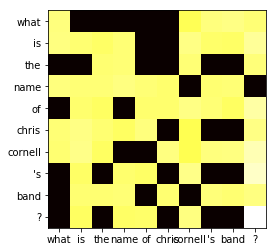

In [133]:
plt.imshow(clf.q_mha1.attn[0][0].detach().numpy(), cmap='hot', interpolation='nearest',)
plt.xticks(np.arange(10), labels=tokens)
plt.yticks(np.arange(10), labels=tokens)

In [ ]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()